# S&P500 Forecasting with Machine Learning
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>


# Download S&P500 (^GSPC) price history

In [51]:
import yfinance as yf

In [52]:
data = yf.Ticker("^GSPC").history(period="max")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-02 00:00:00-04:00,5376.629883,5383.890137,5302.029785,5346.560059,5156450000,0.0,0.0
2024-08-05 00:00:00-04:00,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,0.0,0.0
2024-08-06 00:00:00-04:00,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.0,0.0


<Axes: xlabel='Date'>

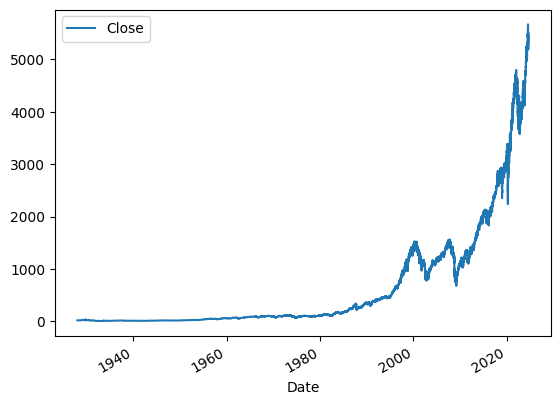

In [53]:
data.plot.line(y="Close",use_index=True)

# Preprocessing

In [54]:
data.drop(labels=['Dividends','Stock Splits'], axis=1,inplace=True)

In [55]:
data['Tomorrow'] = data['Close'].shift(-1)

In [56]:
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)

In [57]:
data = data.loc['1990-01-01':].copy()

# Toy model - Random forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)

In [60]:
train = data.iloc[:-100]
test = data.iloc[-100:]

In [61]:
predictors = ['Close','Volume','Open','High','Low']

In [62]:
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [63]:
from sklearn.metrics import precision_score
import pandas as pd

In [64]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [65]:
precision_score(test['Target'], preds)

0.5384615384615384

In [66]:
combined = pd.concat([test['Target'], preds], axis=1)

<Axes: xlabel='Date'>

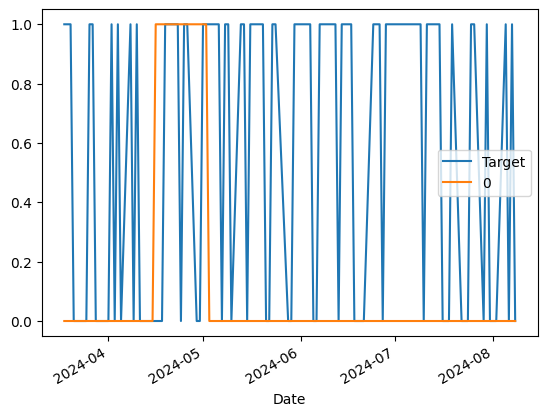

In [67]:
combined.plot()

# Backtesting paradigm

In [68]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [69]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [70]:
predictions = backtest(data, model, predictors)

In [71]:
predictions['Predictions'].value_counts()

,count
Predictions,
0,3502
1,2715


In [72]:
precision_score(predictions['Target'],predictions['Predictions'])

0.5307550644567219

In [73]:
predictions['Target'].value_counts() / predictions.shape[0]

,count
Target,
1,0.535146
0,0.464854


# Using moving averages

In [74]:
horizons = [2, 5, 60, 250, 1000]

In [75]:
new_predictors = []

for horizon in horizons:
  rolling_averages = data.rolling(horizon).mean()
  ratio_column = f'Close_Ratio_{horizon}'
  data[ratio_column] = data['Close'] / rolling_averages['Close']
  trend_column = f'Trend_{horizon}'
  data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
  new_predictors += [ratio_column, trend_column]

new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [76]:
data = data.dropna()

In [77]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=42)

In [78]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= 0.6] = 1
  preds[preds < 0.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [79]:
predictions = backtest(data, model, new_predictors)

In [80]:
predictions['Predictions'].value_counts()

,count
Predictions,
0.0,4419
1.0,797


In [81]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5746549560853199